In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from src.postproces_classificationresults import *
from src.plotting import *
from src.preproces import Handle_Files

import pickle

file_handler = Handle_Files()
model_name = 'SVM'

In [18]:
# only run if you have runned classification in section 
dict_dir = f'D:/Programmering/msc/Masterthesis_S23-Results/dicts/{model_name}'
classification_summaries = file_handler.get_all_filenames_in_dir(dict_dir, substrings=['target', 'f1'])

classificiation_summaries_SVM = {}
nomask_baseline = {}
boruta_RF_features = {} 
mRMR_f_mut_features = {} 
johannes_supervised_features = {}

for classification_summary in classification_summaries:
    with open(f'{dict_dir}/{classification_summary}', 'rb') as file:
        dictionary = pickle.load(file)
        nomask_baseline = {**nomask_baseline, **dictionary['nomask_baseline']}
        boruta_RF_features = {**boruta_RF_features, **dictionary['boruta_RF_features']}
        mRMR_f_mut_features = {**mRMR_f_mut_features, **dictionary['mRMR_f_mut_features']}
        johannes_supervised_features = {**johannes_supervised_features, **dictionary['johannes_supervised_features']}

classificiation_summaries_SVM['nomask_baseline'] = nomask_baseline
classificiation_summaries_SVM['boruta_RF_features'] = boruta_RF_features
classificiation_summaries_SVM['mRMR_f_mut_features'] = mRMR_f_mut_features
classificiation_summaries_SVM['johannes_supervised_features'] = johannes_supervised_features

with open('/'.join([dict_dir, f'target_summaries_{model_name}_f1.pkl']), 'wb') as fp:
    pickle.dump(classificiation_summaries_SVM, fp)

In [2]:
dict_dir = f'D:/Programmering/msc/Masterthesis_S23-Results/dicts/{model_name}'

with open('/'.join([dict_dir, f'classification_summaries_{model_name}_f1.pkl']), 'rb') as file:
    classification_summaries = pickle.load(file)

with open('/'.join([dict_dir, f'target_summaries_{model_name}_f1.pkl']), 'rb') as file:
    target_summaries = pickle.load(file)

with open('/'.join([dict_dir, f'roc_information_{model_name}_f1.pkl']), 'rb') as file:
    roc_information = pickle.load(file)

for dictionary in [classification_summaries, target_summaries, roc_information]:
    dictionary['supervised_features'] = dictionary.pop('johannes_supervised_features')

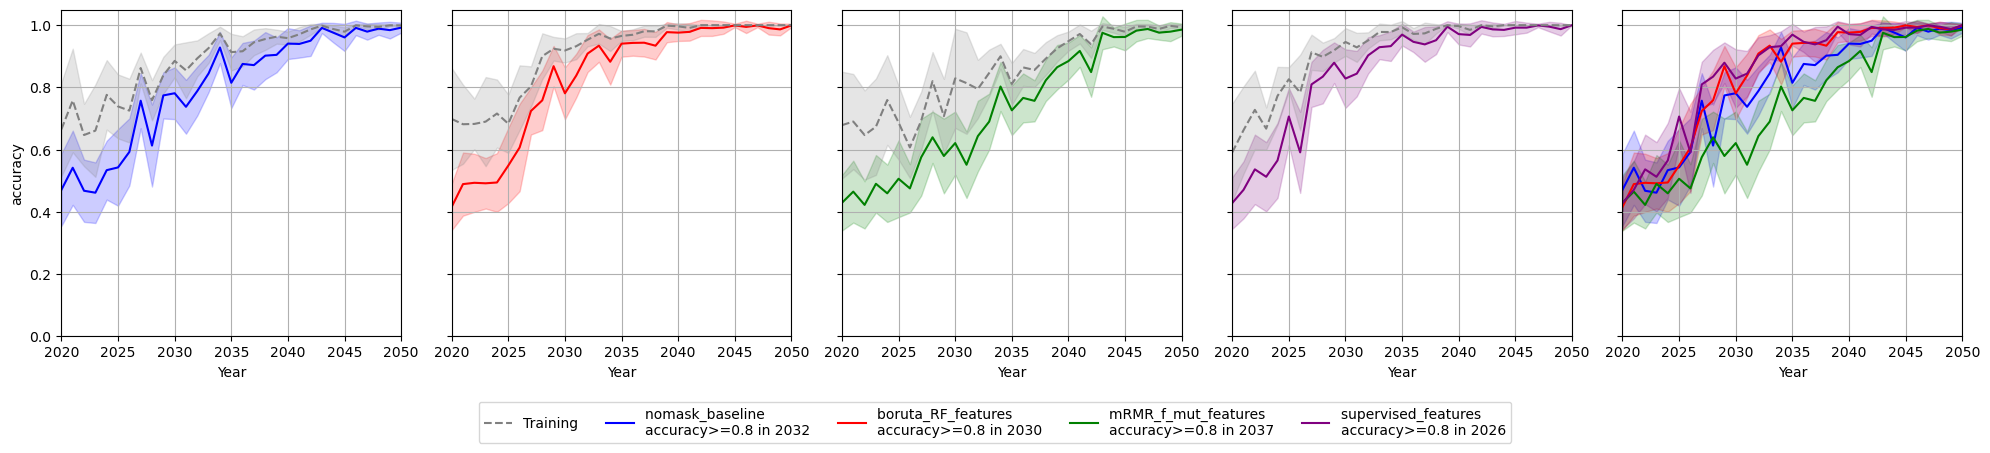

In [3]:
plot_performance(
    classification_summaries, metric='accuracy', years=list(range(2020, 2051)), 
    model_name='Support vector classifier', spread=True, 
    summary_subplot_for_spread=True, 
    include_train=True, 
    report_crossing=True, 
    notitle=True,
    turn_on_subplot_legend=False,
    )

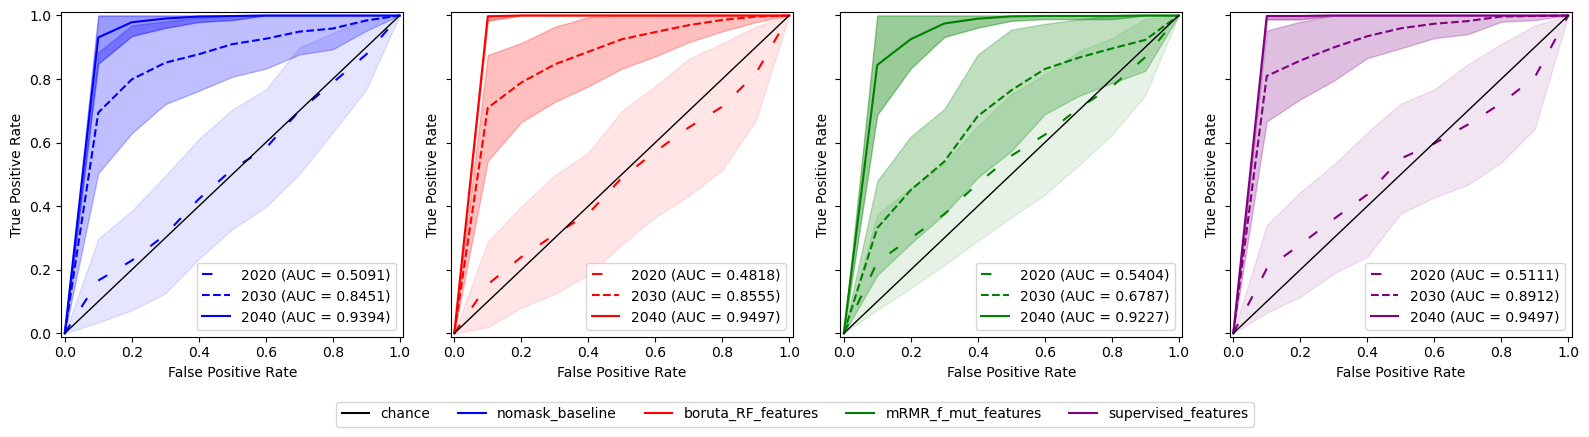

In [4]:
plot_roc_curve(
    roc_information, 
    years=[2020, 2030, 2040], 
    model_name='Support vector classifier', 
    title=None, # uses default title
    spread=True, # spread the feature subsets over the years
    summary_subplot_for_spread=False,
    notitle=True, # turn off title
    )

LISTeresting


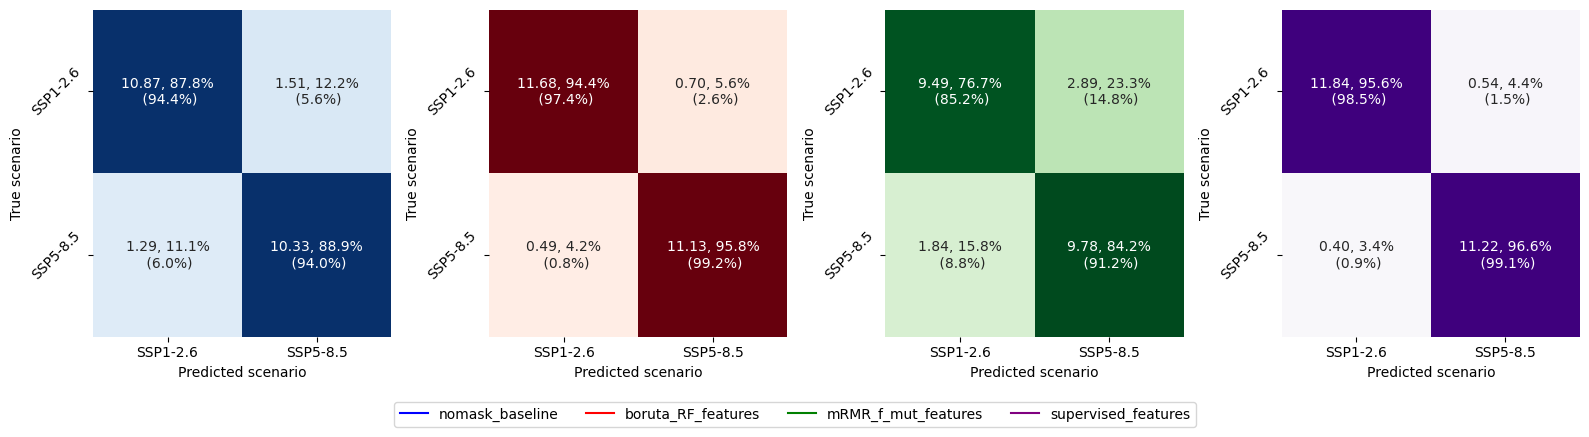

In [5]:
plot_cms(
    target_summaries, 
    model_name='Support vector classifier',
    report_performance=list(range(2035, 2041)),
    notitle=True, # turn off title
    )

In [14]:
accuracy_df_long = create_plotdata_from_summary(classification_summaries, 'accuracy', years=list(range(2020, 2051)), include_train=True)
f1_df_long = create_plotdata_from_summary(classification_summaries, 'f1-score', years=list(range(2020, 2051)), include_train=True)

summary_df_acc = accuracy_df_long[accuracy_df_long['Year'].between(2035, 2040)].groupby(['feature_comb_key']).mean().reset_index()
summary_df_acc = summary_df_acc[['feature_comb_key', 'accuracy', 'training_accuracy']]
summary_df_acc.columns = ['feature_comb_key', 'accuracy test', 'accuracy training']

summary_df_f1 = f1_df_long[f1_df_long['Year'].between(2035, 2040)].groupby(['feature_comb_key']).mean().reset_index()
summary_df_f1 = summary_df_f1[['feature_comb_key', 'f1-score', 'training_f1-score']]
summary_df_f1.columns = ['feature_comb_key', 'f1-score test', 'f1-score training']

summary_df = summary_df_acc.merge(summary_df_f1, on='feature_comb_key')
for col in summary_df.columns:
    if col != 'feature_comb_key':
        summary_df[col] = summary_df[col].round(4)

print(summary_df)

# or 

summary_df_acc = summary_df_acc[['feature_comb_key', 'accuracy test']]
summary_df_acc.columns = ['feature_comb_key', 'estimated \n generalization accuracy']
for col in summary_df_acc.columns:
    if col != 'feature_comb_key':
        summary_df_acc[col] = summary_df_acc[col].round(4)
print(summary_df_acc)

               feature_comb_key  accuracy test  accuracy training  \
0            boruta_RF_features         0.9520             0.9816   
1  johannes_supervised_features         0.9615             0.9877   
2           mRMR_f_mut_features         0.8070             0.8923   
3               nomask_baseline         0.8887             0.9422   

   f1-score test  f1-score training  
0         0.9472             0.9830  
1         0.9586             0.9883  
2         0.8039             0.8955  
3         0.8819             0.9422  
               feature_comb_key  estimated \n generalization accuracy
0            boruta_RF_features                                0.9520
1  johannes_supervised_features                                0.9615
2           mRMR_f_mut_features                                0.8070
3               nomask_baseline                                0.8887


In [7]:
accuracy_df_long = create_plotdata_from_summary(classification_summaries, 'accuracy', years=list(range(2020, 2051)), include_train=True)
print(accuracy_df_long.columns)

mean = accuracy_df_long[accuracy_df_long['Year'].between(2035, 2040)].groupby(['feature_comb_key']).mean().reset_index()
sd = accuracy_df_long[accuracy_df_long['Year'].between(2035, 2040)].groupby(['feature_comb_key']).std().reset_index()

for df in [mean, sd]:
    for col in df.columns:
        if col != 'feature_comb_key':
            df[col] = df[col].round(2)

summary_df_acc = mean.merge(sd, on='feature_comb_key', suffixes=('_mean', '_sd'))
summary_df_acc['estimated classification accuracy'] = '$' + summary_df_acc['accuracy_mean'].astype(str) + '\pm ' + summary_df_acc['accuracy_sd'].astype(str) +'$'

#summary_df_acc = summary_df_acc[['feature_comb_key', 'accuracy', 'training_accuracy']]

summary_df_acc = summary_df_acc[['feature_comb_key', 'estimated classification accuracy']]
summary_df_acc

Index(['Year', 'accuracy', 'feature_comb_key', 'training_accuracy'], dtype='object')


,feature_comb_key,estimated classification accuracy
0,boruta_RF_features,$0.95\pm 0.04$
1,mRMR_f_mut_features,$0.8\pm 0.09$
2,nomask_baseline,$0.88\pm 0.08$
3,supervised_features,$0.96\pm 0.04$


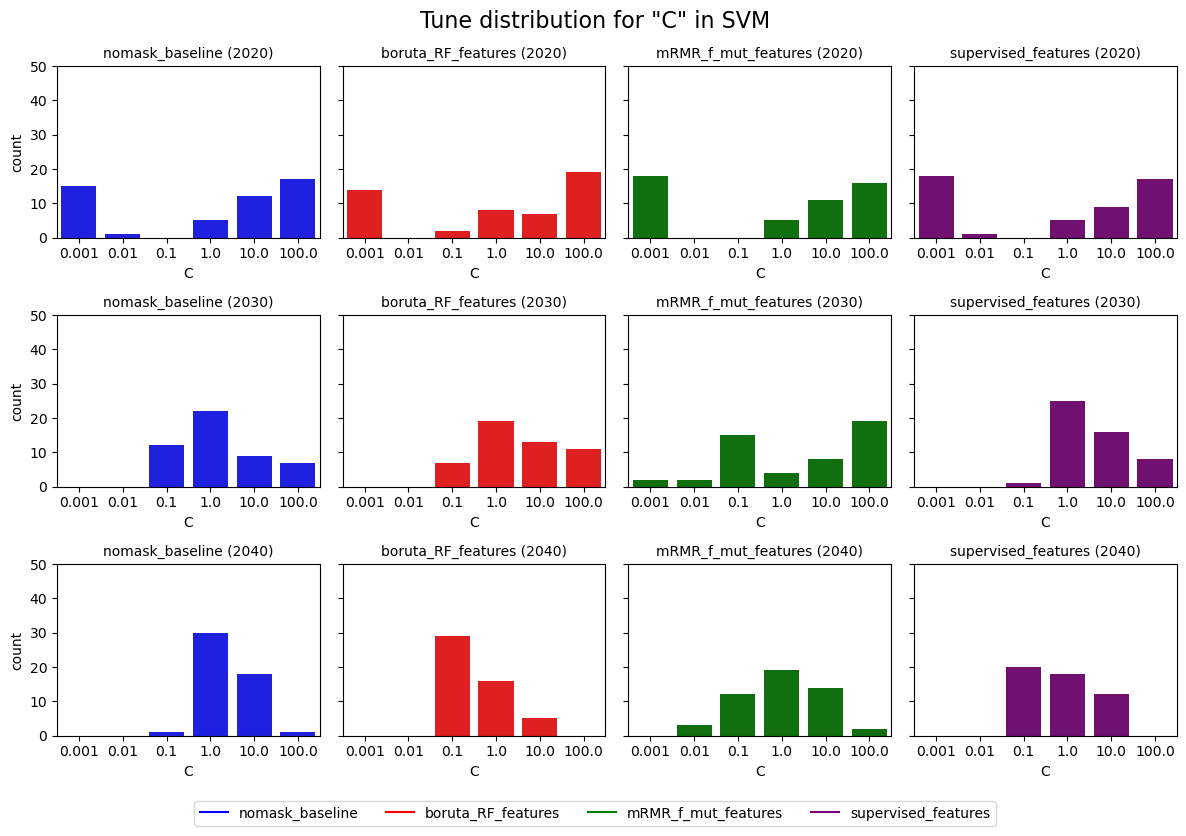

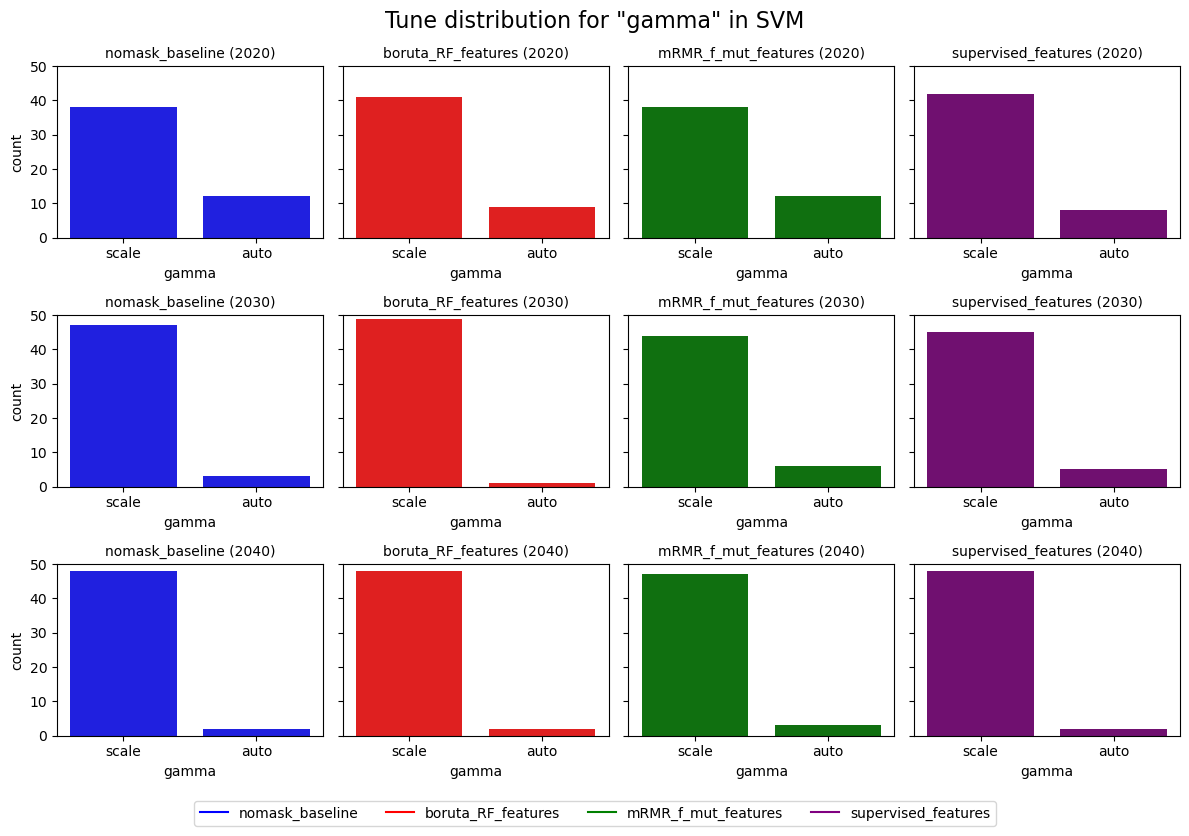

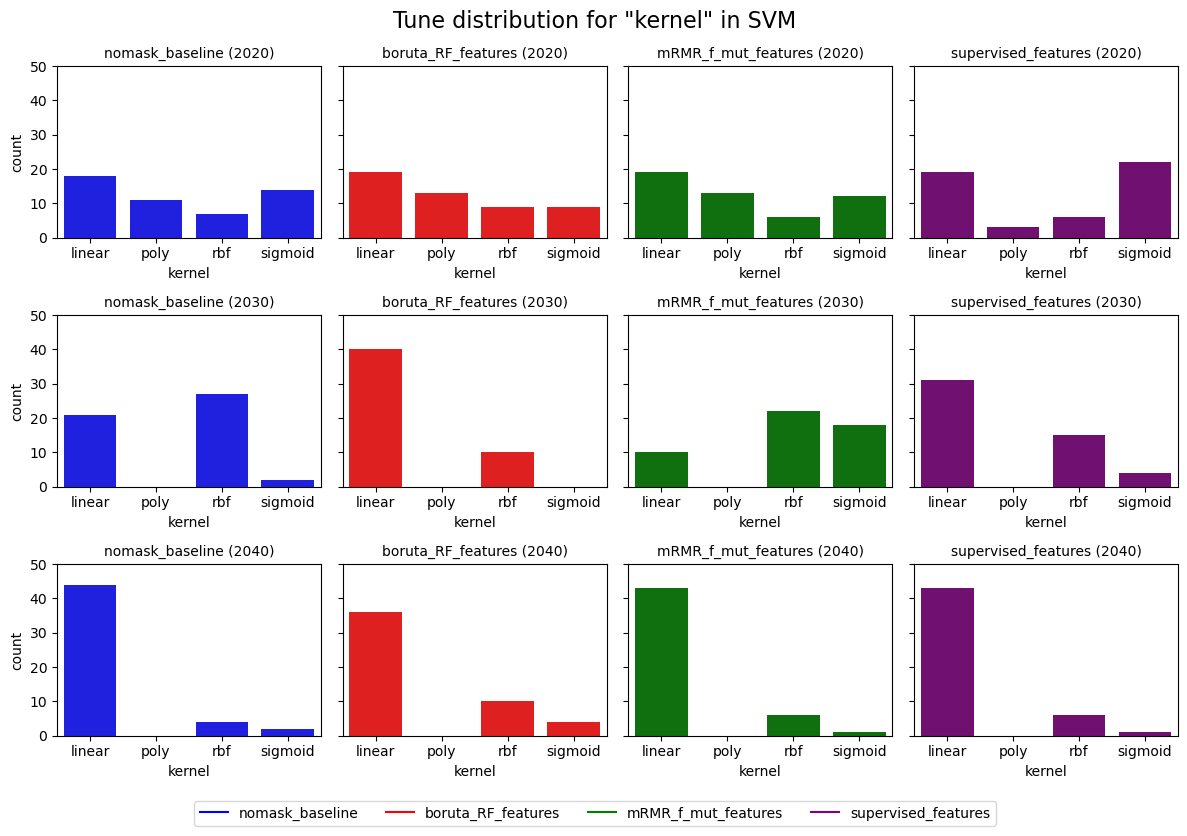

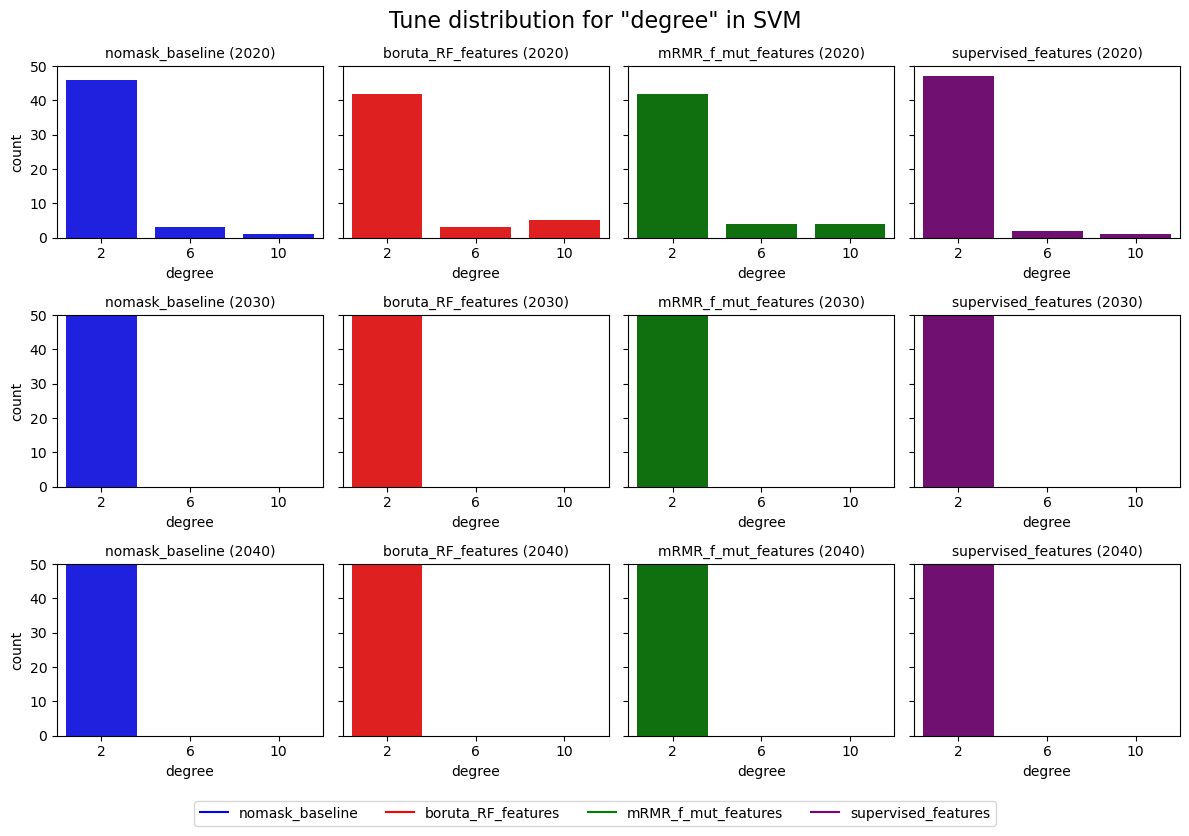

In [6]:
param_grid = {
        'C': np.logspace(-3, 2, 6),
        'gamma': ['scale', 'auto'],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'degree': [2, 6, 10], 
        }

plot_hyperparameters(target_summaries, model_name, years=[2020, 2030, 2040], param_grid=param_grid)